In [1]:
import numpy as np
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, colors, cm

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
})

def sampling_coordinates(n, s):
    return (np.arange(n) - (n-1)/2) * s/n

def evaluate(x, xi, amplitudes, phases):
    return np.sum(amplitudes * np.cos(2.0 * np.pi * xi * x[:, np.newaxis] + phases), axis=-1)

def spatial_display_to_eye(x_a, x_b, z_a, z_b, z_r, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_a, z_b, z_r, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_a, z_b, z_r, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_a, z_b, z_r, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

def compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f):
    """Return the flatland imaging tensor with shape (res_r, res_a, res_b)."""
    # Ratios for projection of plane A and plane B to the pupil plane
    ratio_a = np.reciprocal(1.0 - z_a/z_f)
    ratio_b = np.reciprocal(1.0 - z_b/z_f)
    # Project display samples to the pupil plane
    x_a_at_p = (x_a[np.newaxis, ..., np.newaxis] - x_r[..., np.newaxis, np.newaxis] * (z_a/z_r)) * ratio_a
    x_b_at_p = (x_b[np.newaxis, np.newaxis, ...] - x_r[..., np.newaxis, np.newaxis] * (z_b/z_r)) * ratio_b
    # Compute the lower and upper bounds for each intersection of plane A intervals, plane B intervals and the pupil aperture
    lower_bound = np.maximum(np.maximum(-s_p/2, x_a_at_p - np.abs(ratio_a * w_a/2)), x_b_at_p - np.abs(ratio_b * w_b/2))
    upper_bound = np.minimum(np.minimum( s_p/2, x_a_at_p + np.abs(ratio_a * w_a/2)), x_b_at_p + np.abs(ratio_b * w_b/2))
    # Return the lengths of the intersection intervals normalized by the pupil diameter
    return np.maximum(np.subtract(upper_bound, lower_bound) / s_p, 0.0)

In [2]:
def plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, spatial_size, frequency_size):
    n_p = 99

    x_r = sampling_coordinates(n_r, s_r)

    x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
    xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

    window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
    window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
    xi_p = sampling_coordinates(n_p, n_p/s_p)
    xi_r = sampling_coordinates(n_r, n_r/s_r)

    fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

    axs[0, 0].set_title('Eye spatial domain', fontsize=14)
    axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
    axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
    axs[0, 0].set_aspect('equal')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    axs[0, 0].set_xlim(-spatial_size/2, spatial_size/2)
    axs[0, 0].set_ylim(-spatial_size/2, spatial_size/2)

    axs[0, 0].scatter(*spatial_display_to_eye(*x_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
    axs[0, 0].scatter(x_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
    axs[0, 0].plot(*spatial_display_to_eye(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 0].plot(*spatial_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 0].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')
    axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')
    axs[0, 0].fill(*window_x_r, alpha=0.2, color='lfd:retina')
    axs[0, 0].fill(*spatial_display_to_eye(np.repeat(x_ab[0], 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * w_a/2, 99 * n_a * 99 * n_b),
                                        np.repeat(x_ab[1], 5) + np.tile(np.array([1, -1, -1, 1, np.nan]) * w_b/2, 99 * n_a * 99 * n_b), z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:signal')

    axs[0, 1].set_title('Eye frequency domain', fontsize=14)
    axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
    axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    axs[0, 1].set_xlim(-frequency_size/2, frequency_size/2)
    axs[0, 1].set_ylim(-frequency_size/2, frequency_size/2)

    axs[0, 1].scatter(*frequency_display_to_eye(*xi_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
    axs[0, 1].scatter(xi_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
    axs[0, 1].plot(*frequency_display_to_eye(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye( np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(-np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 98),  np.repeat(np.arange(1, 99) / w_b, 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 98), -np.repeat(np.arange(1, 99) / w_b, 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:signal')
    axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
    axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
    axs[0, 1].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')

    axs[1, 0].set_title('Display spatial domain', fontsize=14)
    axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
    axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
    axs[1, 0].set_aspect('equal')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    axs[1, 0].set_xlim(-spatial_size/2, spatial_size/2)
    axs[1, 0].set_ylim(-spatial_size/2, spatial_size/2)

    axs[1, 0].scatter(*x_ab, color='lfd:signal', zorder=3)
    axs[1, 0].scatter(*spatial_eye_to_display(x_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
    axs[1, 0].plot(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
    axs[1, 0].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), color='lfd:signal')
    axs[1, 0].plot(*spatial_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
    axs[1, 0].fill(np.repeat(x_ab[0], 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * w_a/2, 99 * n_a * 99 * n_b),
                np.repeat(x_ab[1], 5) + np.tile(np.array([1, -1, -1, 1, np.nan]) * w_b/2, 99 * n_a * 99 * n_b), alpha=0.2, color='lfd:signal')

    axs[1, 1].set_title('Display frequency domain', fontsize=14)
    axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
    axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
    axs[1, 1].set_aspect('equal')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xlim(-frequency_size/2, frequency_size/2)
    axs[1, 1].set_ylim(-frequency_size/2, frequency_size/2)

    axs[1, 1].scatter(*xi_ab, color='lfd:signal', zorder=3)
    axs[1, 1].scatter(*frequency_eye_to_display(xi_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
    axs[1, 1].plot(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
    axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), color='lfd:signal')
    axs[1, 1].plot( np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), linestyle='dashed', color='lfd:signal')
    axs[1, 1].plot(-np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), linestyle='dashed', color='lfd:signal')
    axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 98),  np.repeat(np.arange(1, 99) / w_b, 3), linestyle='dashed', color='lfd:signal')
    axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 98), -np.repeat(np.arange(1, 99) / w_b, 3), linestyle='dashed', color='lfd:signal')
    axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
    axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
    axs[1, 1].plot(*frequency_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

In the spatial domain we have:
$$ \large \begin{align*}
    s &= \text{period of the spatial signal} \\
    n &= \text{number of spatial samples in one period of the spatial signal} \\
    \Delta x &= \text{spatial sampling period, i.e., the distance between spatial samples} \\
\end{align*} $$

In the frequency domain we have:
$$ \large \begin{align*}
    \sigma &= \text{period of the signal spectrum} \\
    n &= \text{number of frequency samples in one period of the signal spectrum} \\
    \Delta \xi &= \text{frequency sampling period, i.e., the distance between frequency samples} \\
\end{align*} $$

We can always describe $\Delta x$, $\Delta \xi$ and $\sigma$ in terms of $n$ and $s$:
$$ \large \begin{align*}
    \Delta x &= \frac{s}{n} && (1)\\
    \Delta \xi &= \frac{1}{s} && (2)\\
    \sigma &= \frac{n}{s} && (3)\\
\end{align*} $$

Display frequencies and eye frequencies relate to each other according to:
$$ \large \begin{align*}
    z_{a} \, \xi_{a} + z_{b} \, \xi_{b} &= z_{r} \, \xi_{r} && (4)\\
    (z_{f} - z_{a}) \, \xi_{a} + (z_{f} - z_{b}) \, \xi_{b} &= z_{f} \, \xi_{p} && (5)\\
\end{align*} $$

For a two-dimensional scene it is convenient to choose $z_{f} = \infty$. In addition to simplifying the equations it is also the most comfortable focus distance for the viewer.
$$ \large \begin{align*}
    z_{f} = \infty \implies \xi_{a} + \xi_{b} = \xi_{p} && (6)\\
\end{align*} $$

The $\xi_{r}$ and $\xi_{p}$ axes are described in eye space simply as $\xi_{p} = 0$ and $\xi_{r} = 0$ respectively. Therefore they can be described in display space as:
$$ \large \begin{align*}
    \xi_{p} = 0 &\implies
    \begin{cases}
        \xi_{a} = \frac{-z_{r}}{z_{b} - z_{a}} \xi_{r} \\
        \xi_{b} = \frac{-z_{r}}{z_{a} - z_{b}} \xi_{r} \\
    \end{cases} && (7)\\
    \xi_{r} = 0 &\implies
    \begin{cases}
        \xi_{a} = \frac{z_{b}}{z_{b} - z_{a}} \xi_{p} \\
        \xi_{b} = \frac{z_{a}}{z_{a} - z_{b}} \xi_{p} \\
    \end{cases} && (8)\\
\end{align*} $$

For a pupil with diameter $d_{p}$, the spatial signal is multiplied over the pupil axis by a rectangular function of width $d_{p}$. Therefore, the signal spectrum is convolved over the pupil frequency axis by a $\mathrm{sinc}$ with zeros on every $\xi_{p}$ multiple of $1/d_{p}$.

To avoid interference due to spectral leakage of the pupil from display frequency samples out of the retina frequency axis we will choose:

$$ \large \begin{align*}
    \Delta \xi_{a} = \Delta \xi_{b} = \frac{1}{d_{p}} \implies s_{a} = s_{b} = d_{p} && (9)\\
\end{align*} $$

This way, the display frequency samples also align over the retina frequency axis and induces a period over the retina according to:
$$ \large \begin{align*}
    s_{r} = \left\lvert \frac{z_r}{z_b - z_a} \right\rvert d_{p} && (10)\\
\end{align*} $$

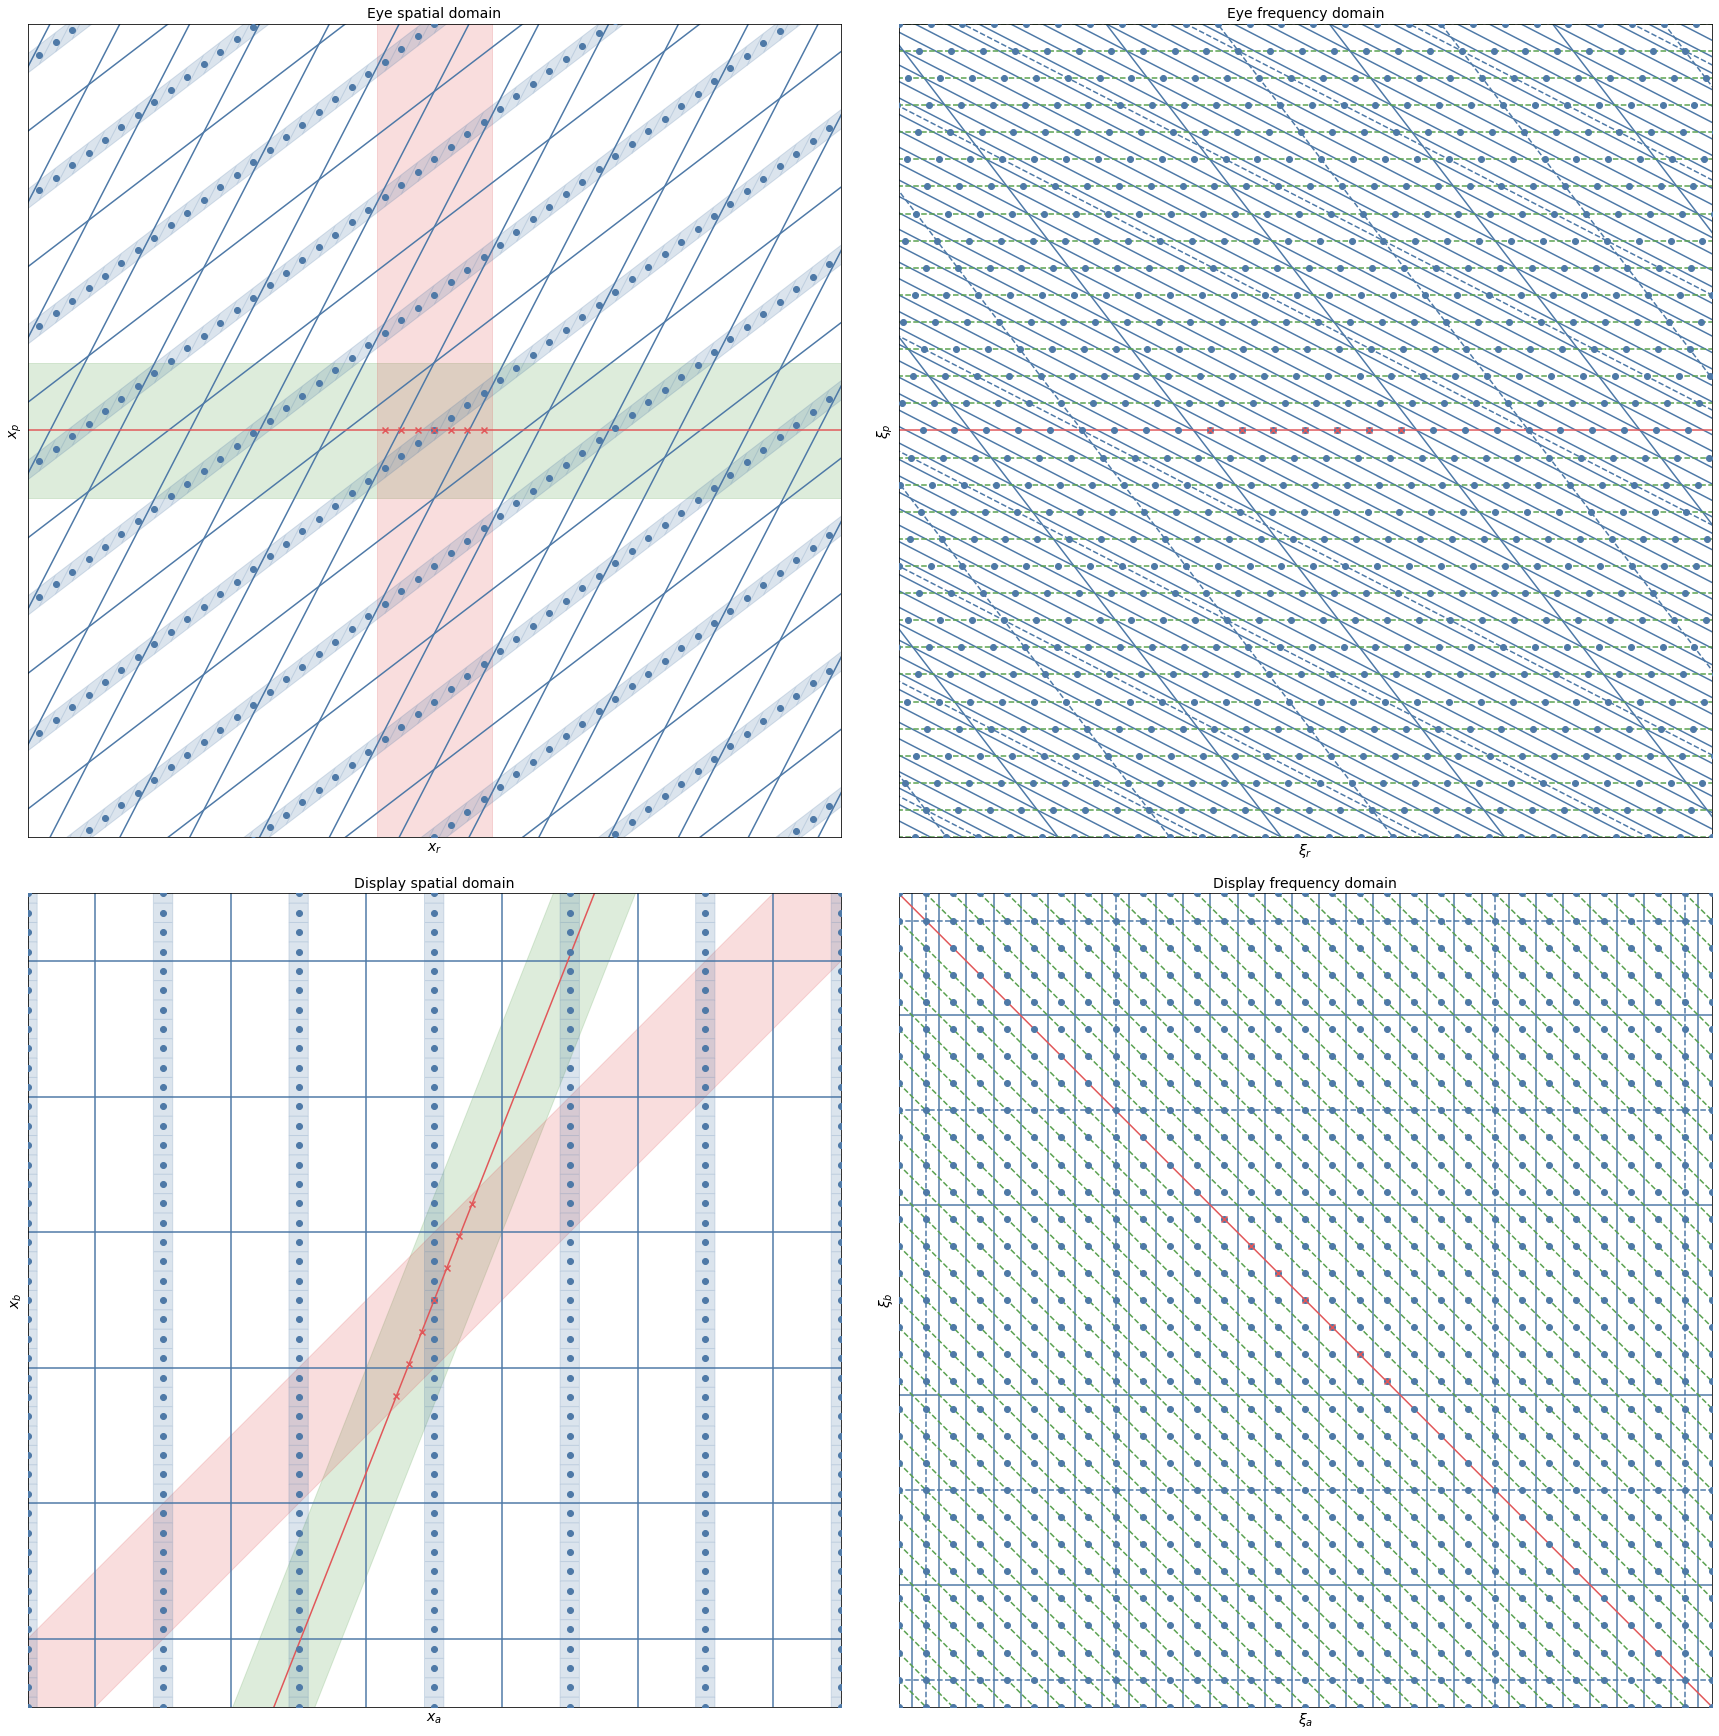

In [3]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 1
n_b = 7
n_r = 7

s_p = 5.0

s_a = s_p
s_b = s_p

s_r = np.abs(z_r/(z_b - z_a)) * s_p

w_a = (s_a / n_a)
w_b = (s_b / n_b)

w_a = w_b

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 30, 6)

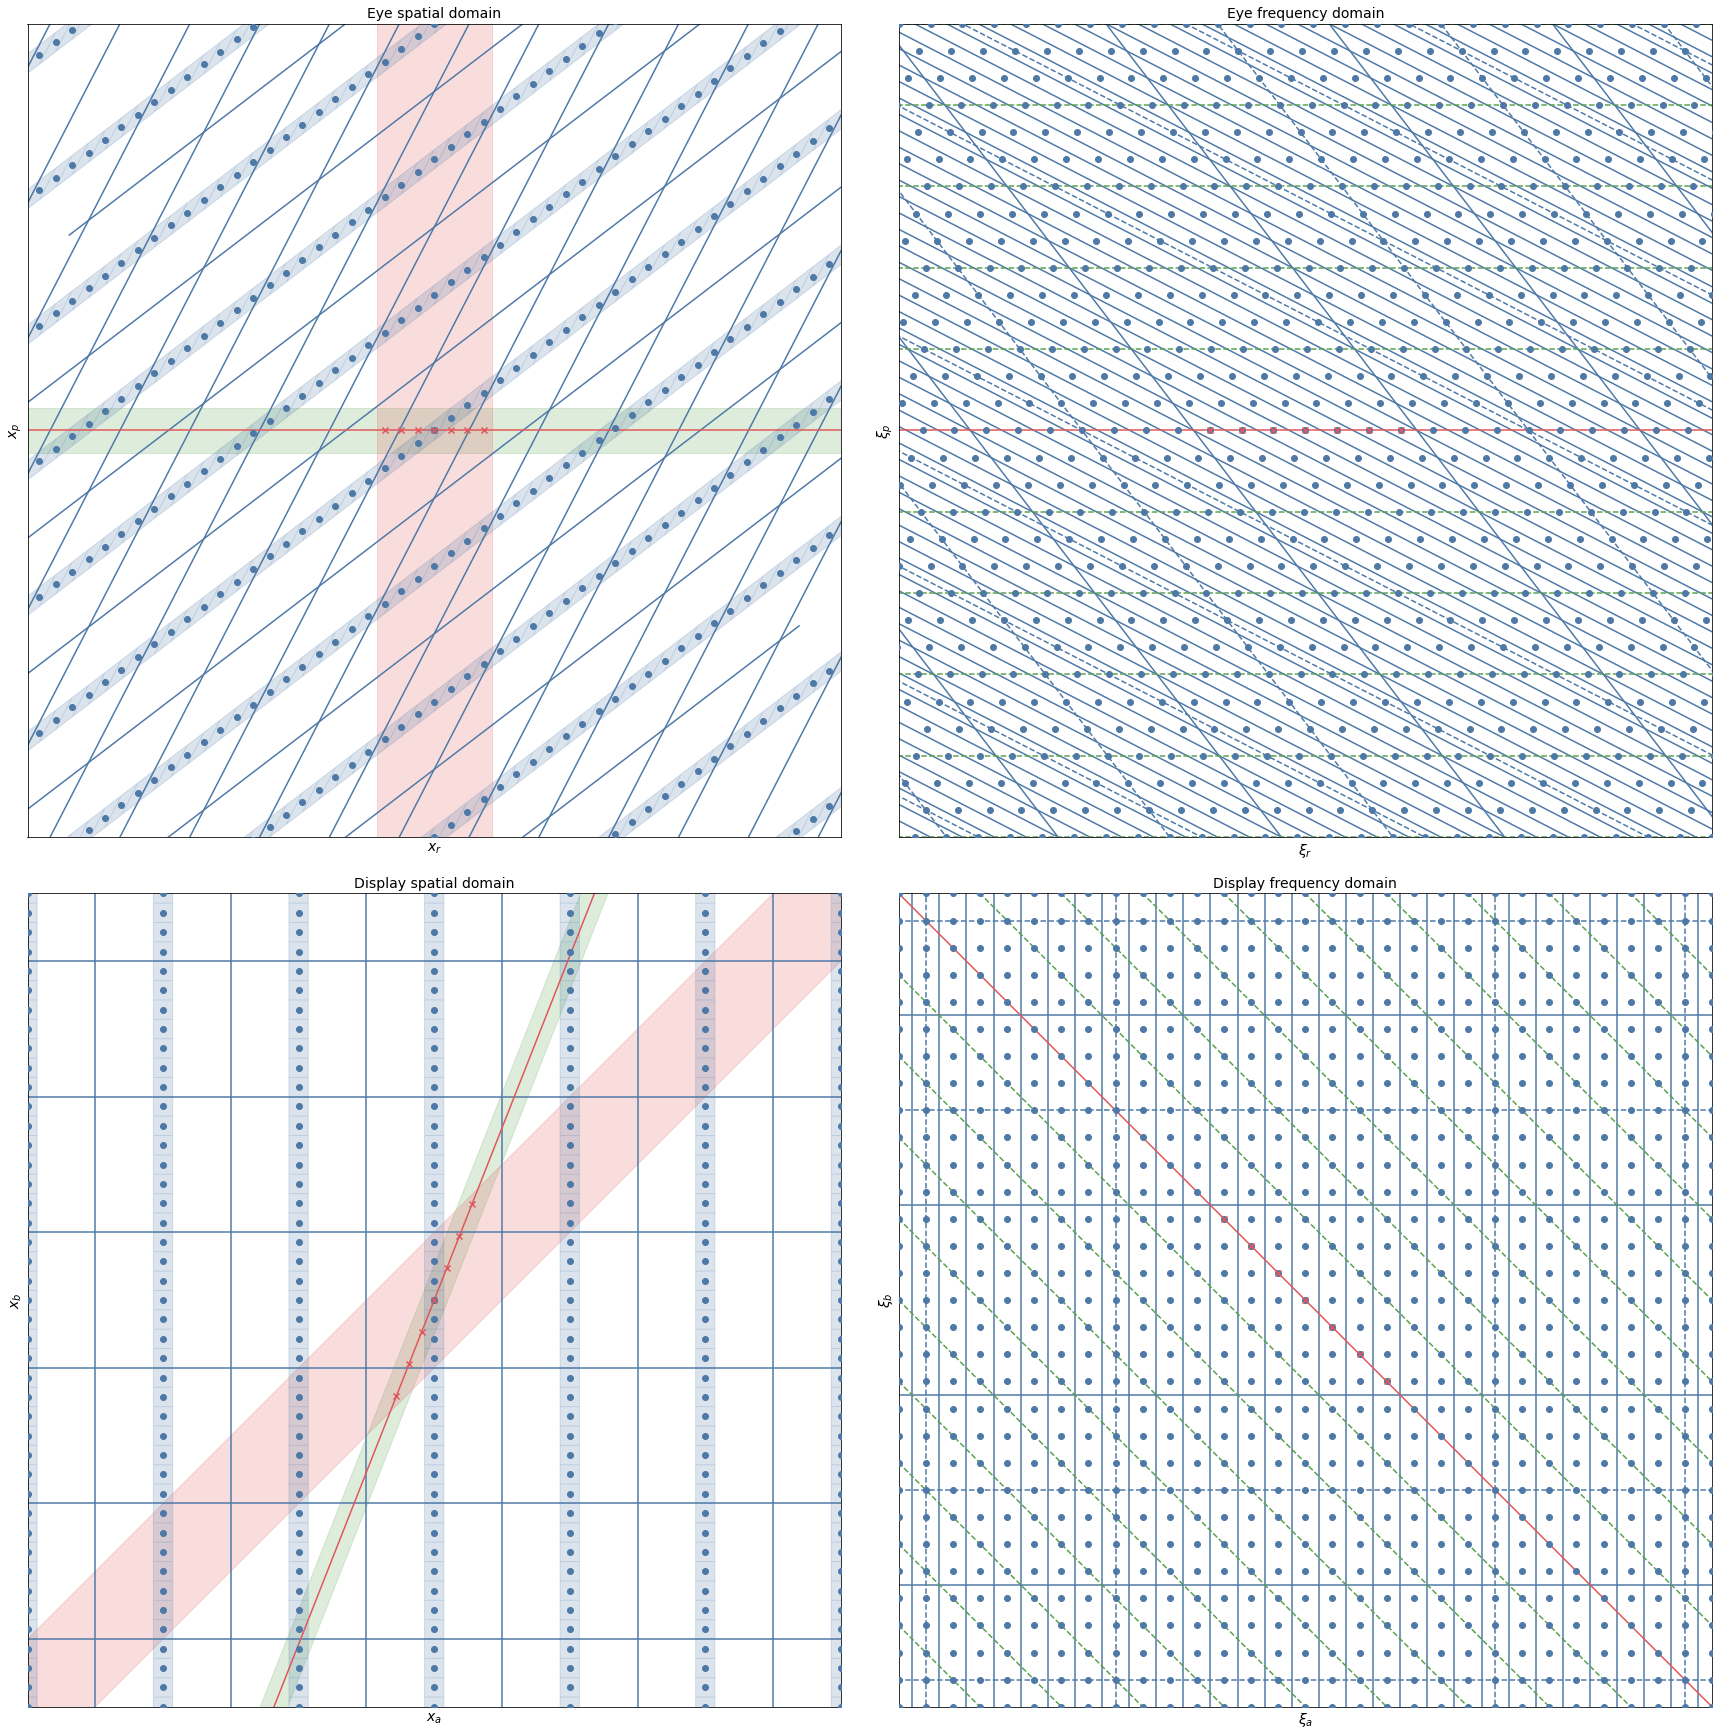

In [4]:
s_a = s_p * 3
s_b = s_p * 3

s_r = np.abs(z_r/(z_b - z_a)) * s_p * 3

w_a = (s_a / n_a)
w_b = (s_b / n_b)

w_a = w_b

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 90, 2)

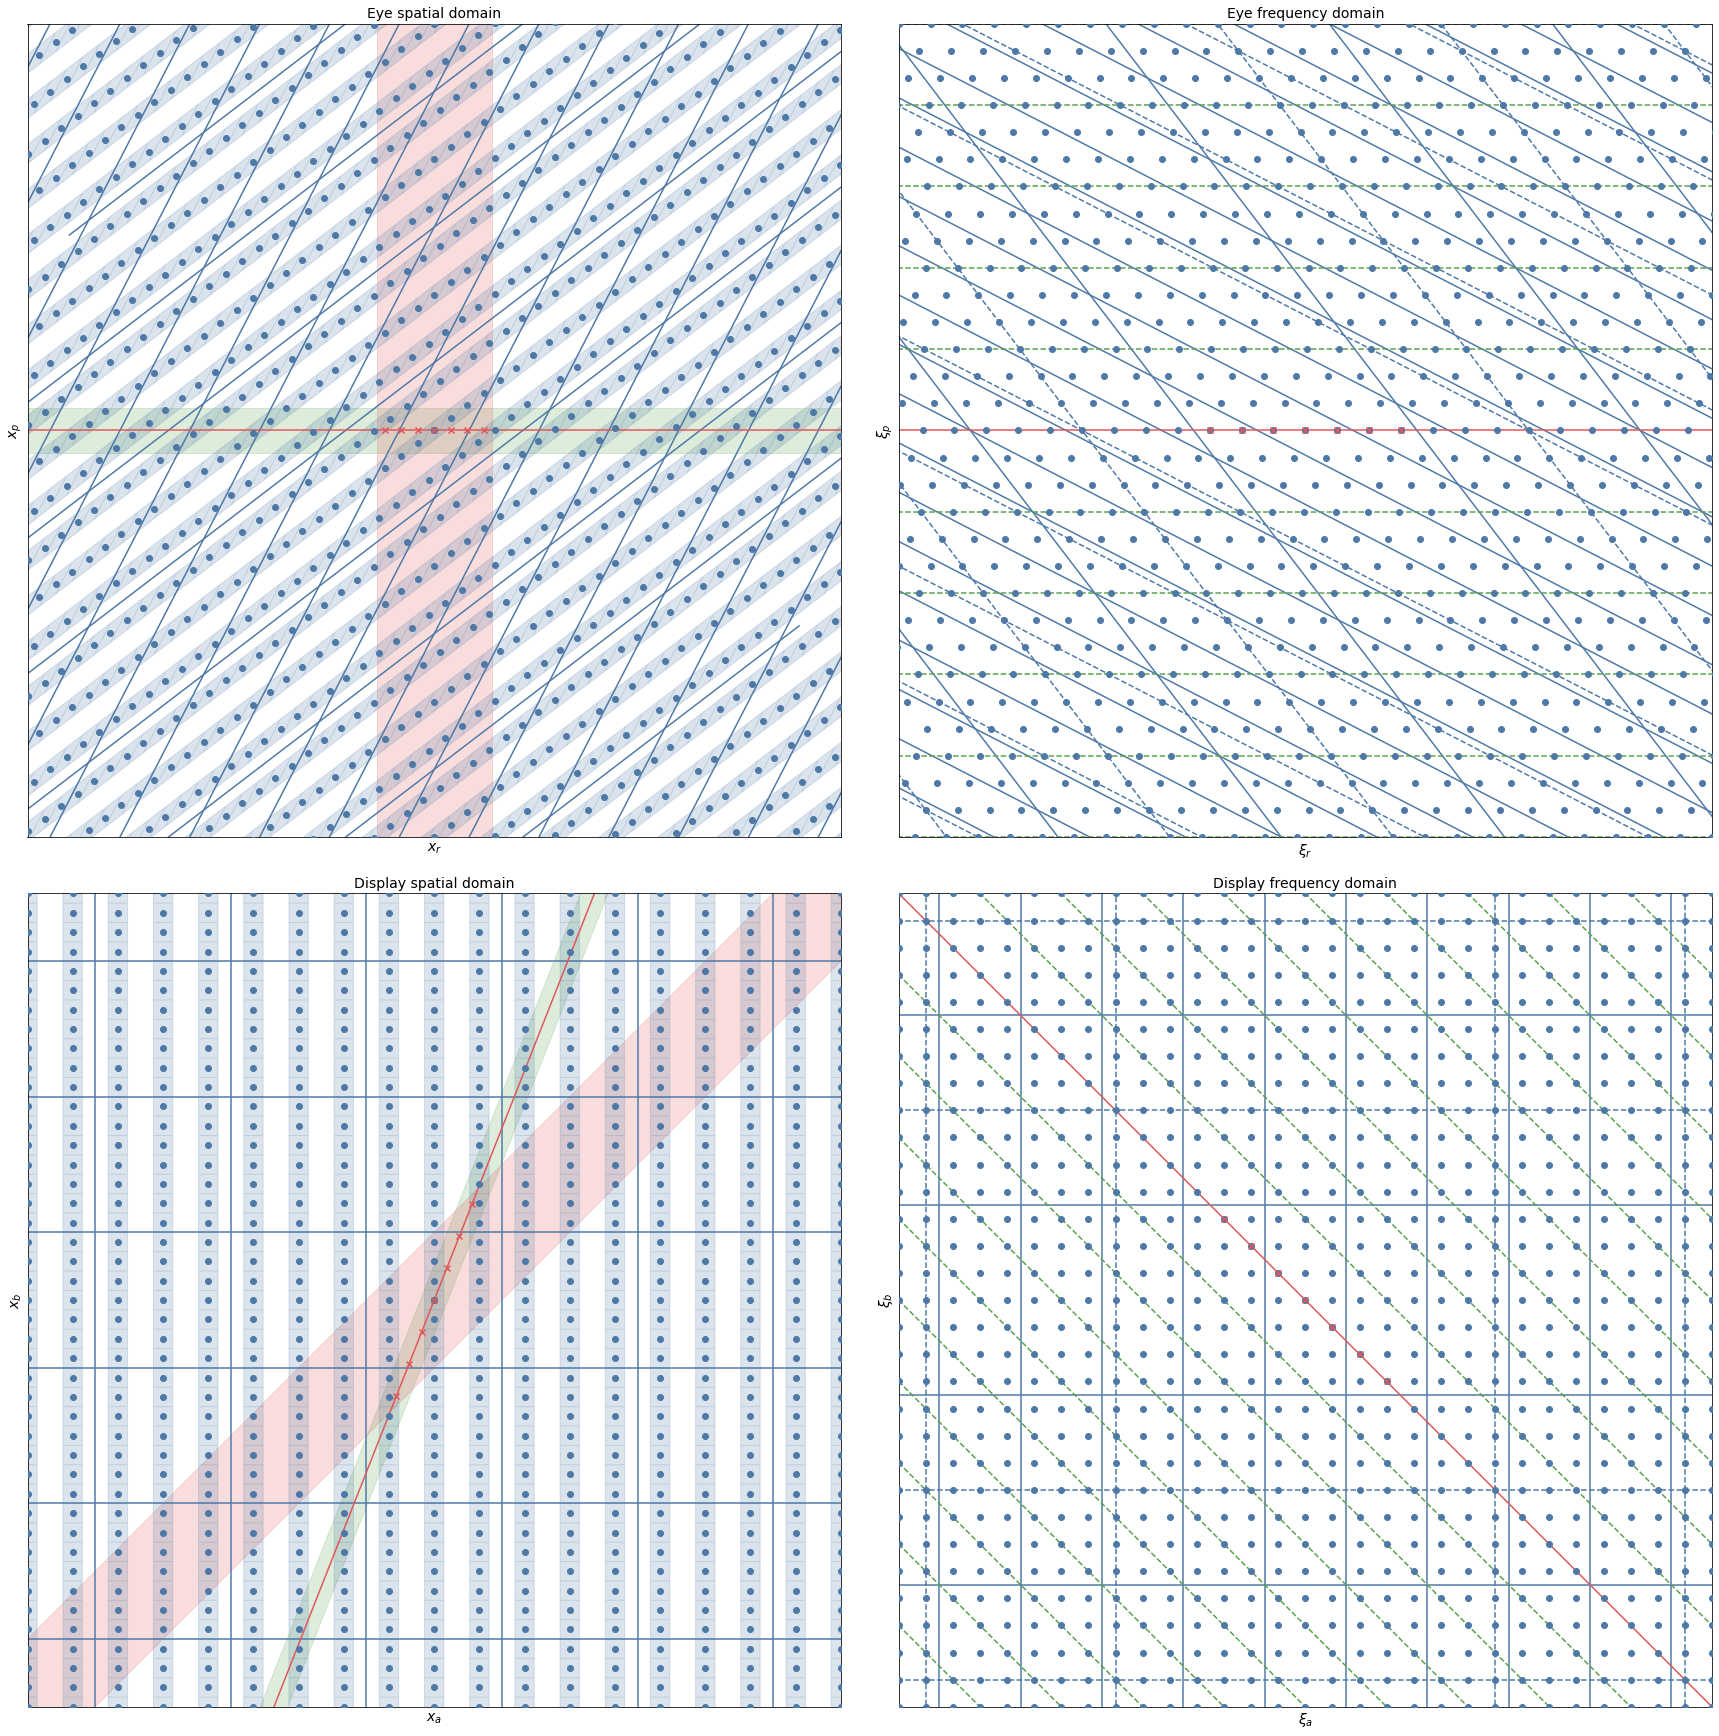

In [5]:
n_a = 3

w_a = (s_a / n_a)
w_b = (s_b / n_b)

w_a = w_b

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 90, 2)

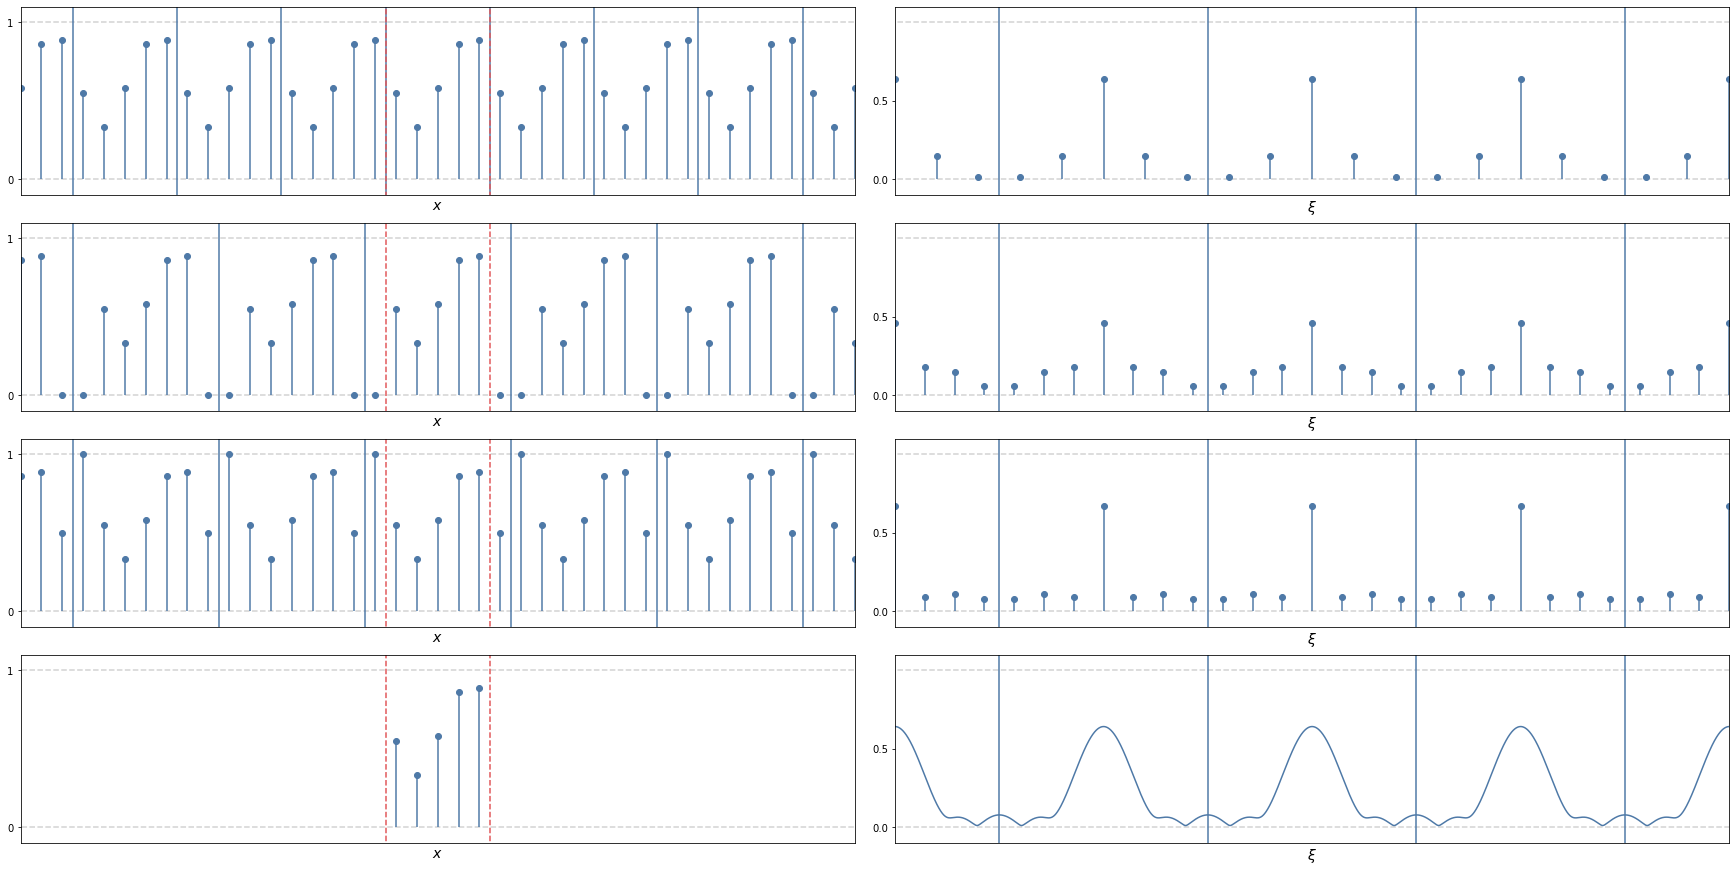

In [6]:
x_r = sampling_coordinates(5 * 7 * 11, 5 * 7 * 11)
x_5 = sampling_coordinates(11, 5 * 11)
x_7 = sampling_coordinates(11, 7 * 11)

samples = np.array([0.55, 0.33, 0.58, 0.86, 0.89])
samples_a = np.array([0.0, 0.55, 0.33, 0.58, 0.86, 0.89, 0.0])
samples_b = np.array([1.0, 0.55, 0.33, 0.58, 0.86, 0.89, 0.5])

spectrum_0 = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples)))/5
spectrum_a = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_a)))/7
spectrum_b = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_b)))/7
spectrum = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples), 999))/5

samples_ext = np.tile(samples, 7 * 11)
samples_a_ext = np.tile(samples_a, 5 * 11)
samples_b_ext = np.tile(samples_b, 5 * 11)

fig, axs = pyplot.subplots(4, 2, constrained_layout=True, figsize=(24, 12))

for ax in axs[:, 0]:
    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_xticks([])
    ax.set_xlim(-20, 20)
    ax.set_yticks([-1.0, 0.0, 1.0])
    ax.set_ylim(-0.1, 1.1)
    ax.hlines([0.0, 1.0], -100, 100, linestyle='dashed', color='lightgrey', zorder=-1)

for ax in axs[:, 1]:
    ax.set_xlabel(r'$\xi$', fontsize=14)
    ax.set_xticks([])
    ax.set_xlim(-2, 2)
    ax.set_yticks([0.0, 0.5])
    ax.set_ylim(-0.1, 1.1)
    ax.hlines([0.0, 1.0], -100, 100, linestyle='dashed', color='lightgrey', zorder=-1)

[ln.set_color('lfd:signal') for ln in axs[0, 0].stem(x_r, samples_ext, basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[1, 0].stem(x_r, samples_a_ext, basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[2, 0].stem(x_r, samples_b_ext, basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[3, 0].stem(sampling_coordinates(5, 5), samples, basefmt='none')[0:2]]

axs[0, 0].plot(np.repeat(x_5, 3) - 5/2, [-10, 10, np.nan]*11, color='lfd:signal')
axs[1, 0].plot(np.repeat(x_7, 3) - 7/2, [-10, 10, np.nan]*11, color='lfd:signal')
axs[2, 0].plot(np.repeat(x_7, 3) - 7/2, [-10, 10, np.nan]*11, color='lfd:signal')

axs[0, 0].plot(np.repeat([0, 5], 3) - 5/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')
axs[1, 0].plot(np.repeat([0, 5], 3) - 5/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')
axs[2, 0].plot(np.repeat([0, 5], 3) - 5/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')
axs[3, 0].plot(np.repeat([0, 5], 3) - 5/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')

[ln.set_color('lfd:signal') for ln in axs[0, 1].stem(sampling_coordinates(5 * 11, 11), np.tile(np.abs(spectrum_0), 11), basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[1, 1].stem(sampling_coordinates(7 * 11, 11), np.tile(np.abs(spectrum_a), 11), basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[2, 1].stem(sampling_coordinates(7 * 11, 11), np.tile(np.abs(spectrum_b), 11), basefmt='none')[0:2]]

axs[3, 1].plot(sampling_coordinates(999 * 11, 11), np.tile(np.abs(spectrum), 11), color='lfd:signal')

axs[0, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')
axs[1, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')
axs[2, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')
axs[3, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')

pass